{'Expansión 92-99': {'zinc_valor_musd': 151.608925, 'precio_usd_oz': 0.78125}, 'Crisis 00-05': {'zinc_valor_musd': 146.0711, 'precio_usd_oz': 0.455}, 'Expansión 06-13': {'zinc_valor_musd': 750.9083, 'precio_usd_oz': 1.0362500000000001}, 'Recesión 14-23': {'zinc_valor_musd': 1247.0563500000003, 'precio_usd_oz': 1.19}}


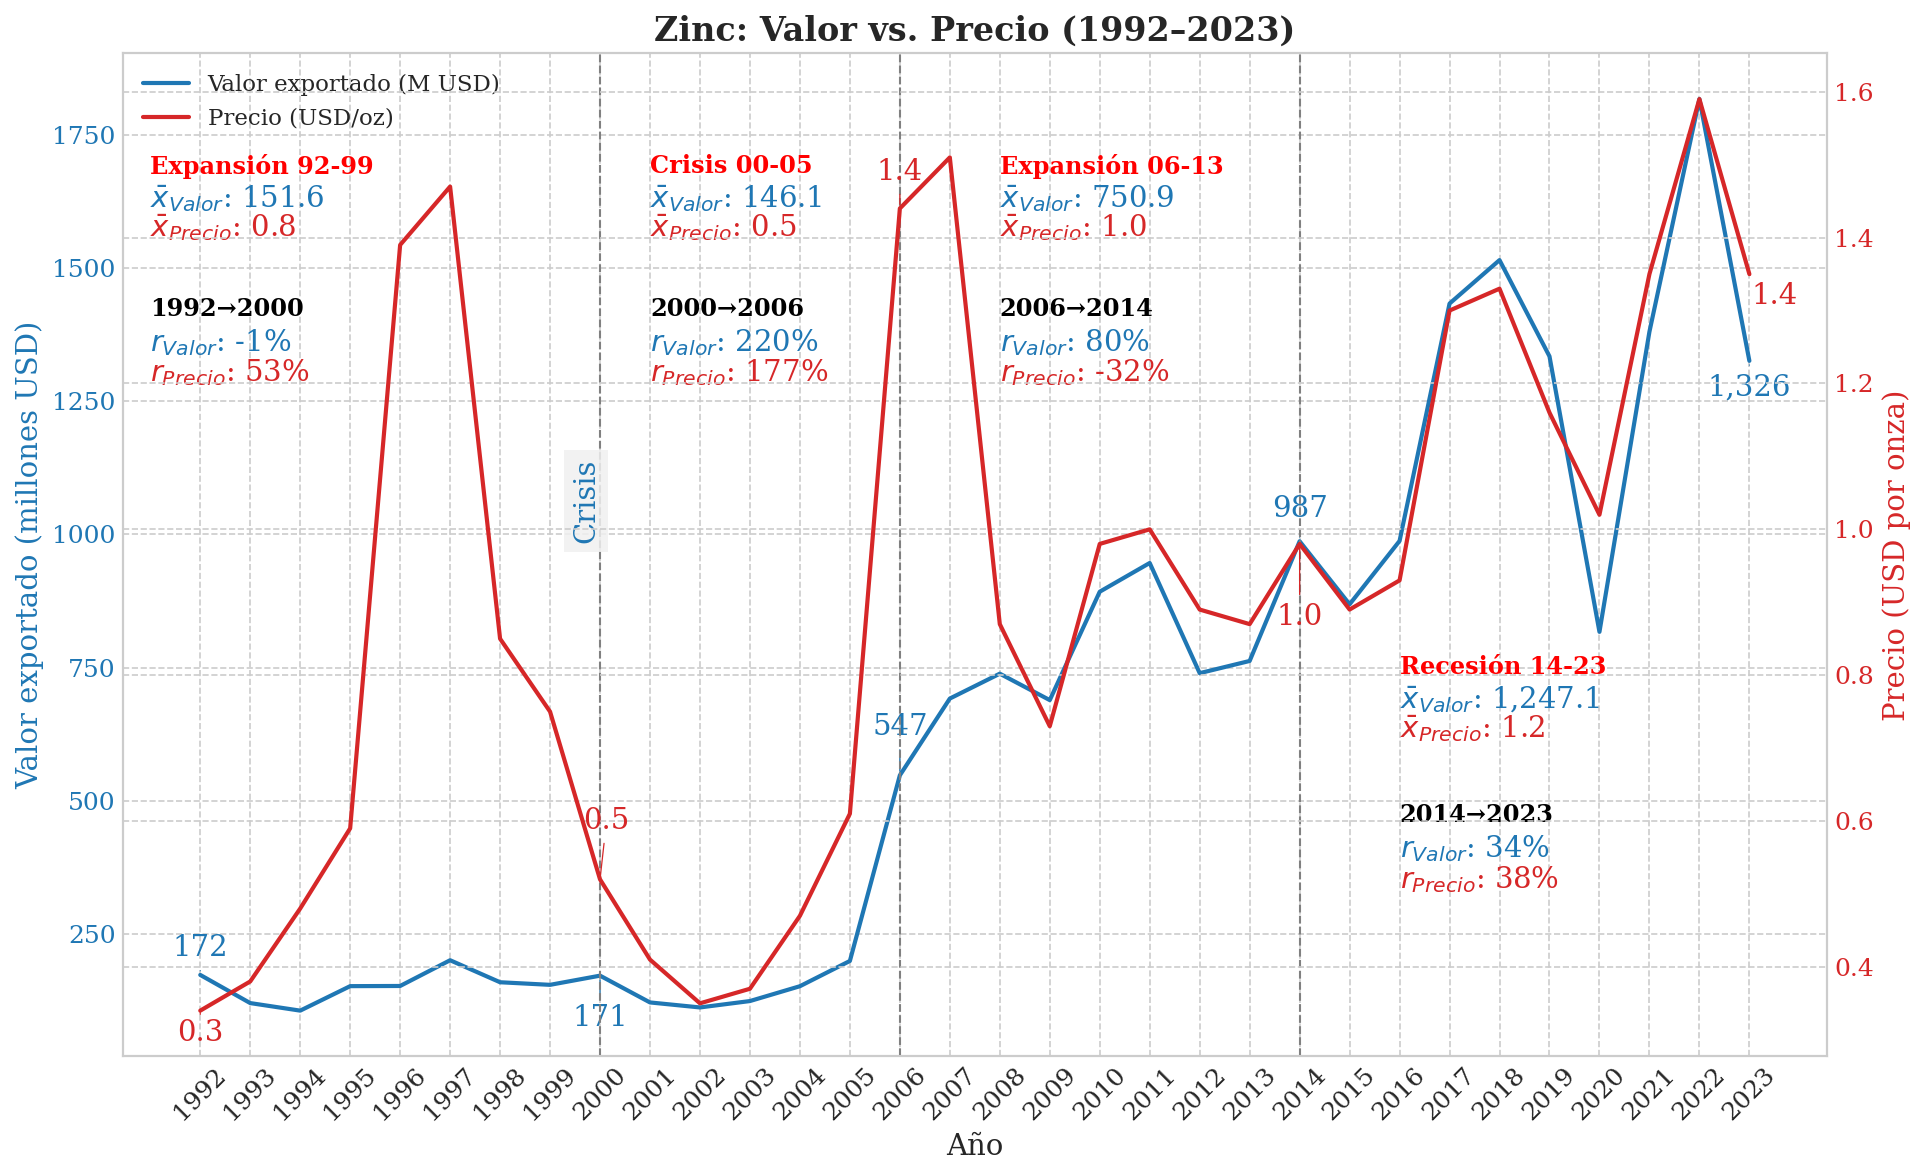

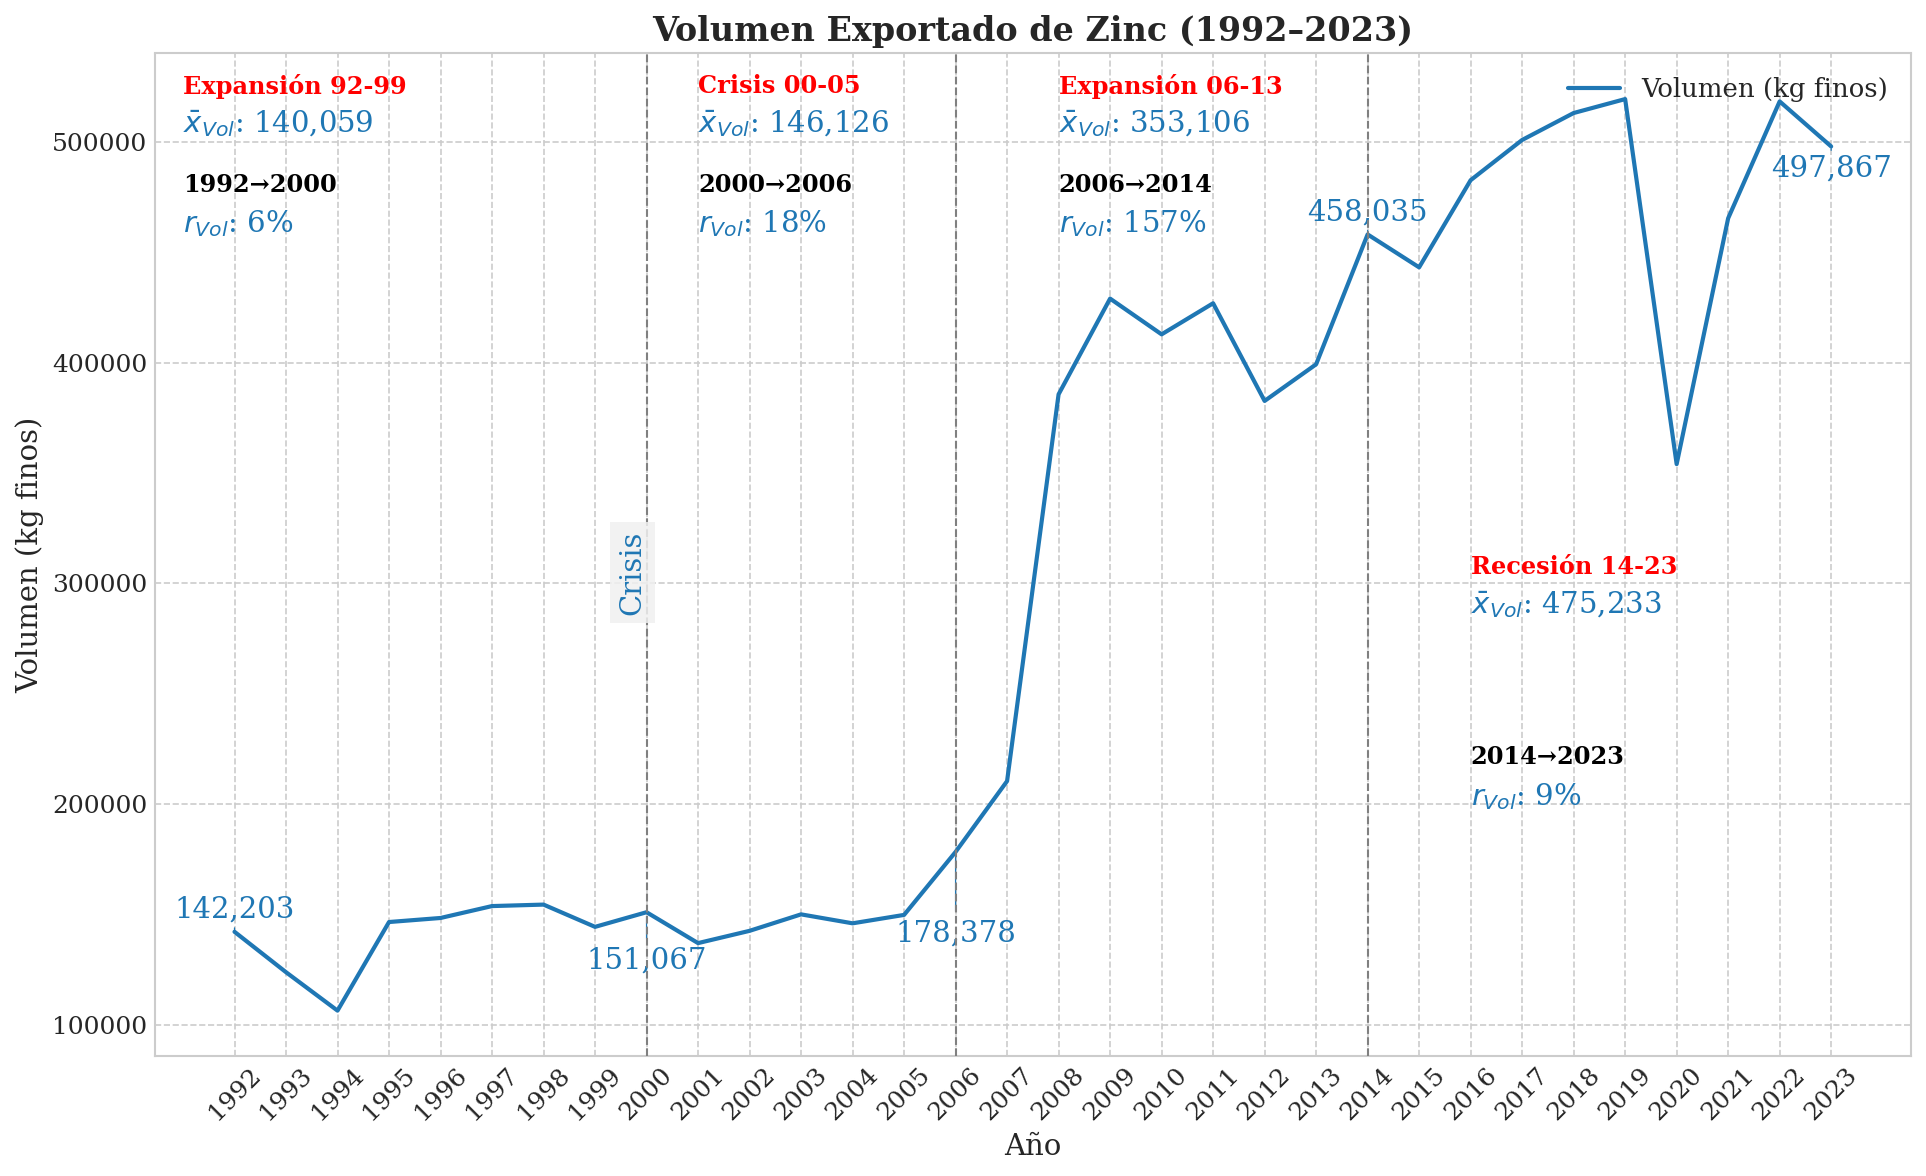

In [2]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi
)

# 0. Ciclos y carpetas
periods = {
    "Expansión 92-99": slice(1992, 1999),
    "Crisis 00-05":    slice(2000, 2005),
    "Expansión 06-13": slice(2006, 2013),
    "Recesión 14-23":  slice(2014, 2023),
}
output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16,   "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150,      "savefig.bbox": "tight",
})

# 1. Datos ────────────────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_zinc = (pd.read_sql(
        "SELECT año, zinc_volumen, zinc_valor FROM exportaciones_minerales_totales "
        "WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio = (pd.read_sql(
        "SELECT año, zinc AS precio_usd_oz "
        "FROM precio_oficial_minerales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )

df = df_zinc.join(df_precio, how="inner")
df["zinc_valor_musd"] = df["zinc_valor"] / 1_000     # miles → millones
df.drop(columns="zinc_valor", inplace=True)

# ───────────────────────  GRÁFICA DUAL AXIS (valor-precio) ───────────────────────
cols     = ["zinc_valor_musd", "precio_usd_oz"]
abbr     = {"zinc_valor_musd": "Valor", "precio_usd_oz": "Precio"}
colors   = {"zinc_valor_musd": "#1f77b4", "precio_usd_oz": "#d62728"}

cols_dual = ["zinc_valor_musd", "precio_usd_oz"]

cycle_stats = {
    nombre: df.loc[rango, cols_dual].mean().to_dict()
    for nombre, rango in periods.items()
}
print(cycle_stats)
hitos_v       = {2000: "Crisis", 2006: "Expansión", 2014: "Recesión"}
hitos_offset  = {yr: .60 for yr in hitos_v}

anot_years = [1992, 2000, 2006, 2014, 2023]
annotation_offsets = {
    "zinc_valor_musd": {
        1992:(0,50), 2000:(0,-80), 2006:(0,90), 2014:(0,60), 2023:(0,-50)
    },
    "precio_usd_oz": {
        1992:(0,-0.03),  2000:(0.13,0.08),  2006:(0,0.05), 2014:(0,-0.1), 2023:(0.5,-0.03)
    },
}
growth_periods        = [(1992,2000),(2000,2006),(2006,2014),(2014,2023)]
period_growth_offsets = {
    "1992-2000": (1991,0.76), "2000-2006":(2001,0.76),
    "2006-2014": (2008,0.76), "2014-2023":(2016,0.26)
}
cycle_text_offsets = {
    "Expansión 92-99": (1991,0.9),
    "Crisis 00-05":    (2001,0.9),
    "Expansión 06-13": (2008,0.9),
    "Recesión 14-23":  (2016,0.4),
}

fig, ax_val = plt.subplots(figsize=(13,8))
ax_price    = ax_val.twinx()

# series
ax_val.plot(df.index, df["zinc_valor_musd"], label="Valor exportado (M USD)",
            color=colors["zinc_valor_musd"])
ax_price.plot(df.index, df["precio_usd_oz"],   label="Precio (USD/oz)",
            color=colors["precio_usd_oz"])

# helpers
add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"linewidth":1})
add_cycle_means_multi(ax_val, cycle_stats, cycle_text_offsets,
                      abbr, colors, line_spacing=df["zinc_valor_musd"].max()*0.03,
                      value_fmt="{:,.1f}")
add_year_value_annotations(
    ax_val,   df, anot_years, ["zinc_valor_musd"],
    {"zinc_valor_musd": annotation_offsets["zinc_valor_musd"]},
    {"zinc_valor_musd": colors["zinc_valor_musd"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price, df, anot_years, ["precio_usd_oz"],
    {"precio_usd_oz": annotation_offsets["precio_usd_oz"]},
    {"precio_usd_oz": colors["precio_usd_oz"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)
add_period_growth_annotations_multi(
    ax_val, df, growth_periods, cols,
    period_growth_offsets, colors, abbr
)

# etiquetas
ax_val.set_title(f"Zinc: Valor vs. Precio ({df.index[0]}–{df.index[-1]})",
                 fontweight="bold")
ax_val.set_xlabel("Año")
ax_val.set_ylabel("Valor exportado (millones USD)", color=colors["zinc_valor_musd"])
ax_price.set_ylabel("Precio (USD por onza)",         color=colors["precio_usd_oz"])
ax_val.tick_params(axis="y", labelcolor=colors["zinc_valor_musd"])
ax_price.tick_params(axis="y", labelcolor=colors["precio_usd_oz"])
ax_val.set_xticks(df.index[::max(1,len(df)//31)])
ax_val.tick_params(axis="x", rotation=45)

# leyenda filtrada
h,l = ax_val.get_legend_handles_labels()
h2,l2 = ax_price.get_legend_handles_labels()
hl = [(x,y) for x,y in zip(h+h2,l+l2) if not y.startswith('_')]
if hl: ax_val.legend(*zip(*hl), loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir,"zinc_valor_precio_dual_axis.png"), dpi=300)
plt.show()

# ────────────────  GRÁFICA DE VOLUMEN ────────────────────────────────
colors_vol = {"zinc_volumen": "tab:blue"}
abbr_vol   = {"zinc_volumen": "Vol"}

cycle_stats_vol = {n: df.loc[s, ["zinc_volumen"]].mean().to_dict()
                   for n,s in periods.items()}

annotation_offsets_vol = {
    "zinc_volumen": {
        1992:(0,1e4), 2000:(0,-2.2e4), 2006:(0,-3.7e4),
        2014:(0,1e4), 2023:(0,-1e4)
    }
}
growth_periods_vol        = growth_periods
period_growth_offsets_vol = {
    "1992-2000": (1991,0.9), "2000-2006":(2001,0.9),
    "2006-2014": (2008,0.9), "2014-2023":(2016,0.42)
}
cycle_text_offsets_vol    = {
    "Expansión 92-99": (1991,0.98),
    "Crisis 00-05":    (2001,0.98),
    "Expansión 06-13": (2008,0.98),
    "Recesión 14-23":  (2016,0.50),
}

fig_v, ax_v = plt.subplots(figsize=(13,8))
ax_v.plot(df.index, df["zinc_volumen"], color=colors_vol["zinc_volumen"],
          label="Volumen (kg finos)")

add_hitos(ax_v, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})
add_cycle_means_multi(ax_v, cycle_stats_vol, cycle_text_offsets_vol,
                      abbr_vol, colors_vol,
                      line_spacing=df["zinc_volumen"].max()*0.03)
add_year_value_annotations(
    ax_v, df, anot_years, ["zinc_volumen"],
    annotation_offsets_vol, colors_vol, arrow_lw=0.6
)
add_period_growth_annotations_multi(
    ax_v, df, growth_periods_vol,
    ["zinc_volumen"], period_growth_offsets_vol,
    colors_vol, abbr_vol
)

ax_v.set_title(f"Volumen Exportado de Zinc ({df.index[0]}–{df.index[-1]})",
               fontweight="bold")
ax_v.set_xlabel("Año")
ax_v.set_ylabel("Volumen (kg finos)")
ax_v.set_xticks(df.index[::max(1,len(df)//31)])
ax_v.tick_params(axis="x", rotation=45)
ax_v.legend(loc="upper right", fontsize=12.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir,"zinc_volumen.png"), dpi=300)
plt.show()
